# KELT-20: CHEOPS occultations

## Data download

In [28]:
import CONAN
CONAN.__version__

'3.3.12'

In [ ]:
from CONAN.get_files import get_CHEOPS_data
df = get_CHEOPS_data("KELT-20")
df.search( filters = { "pi_name"         : {"contains":["LENDL"]}, 
                       "data_arch_rev"   : {"equal":[3]},
                       "status_published": {"equal":[True]}
                     })

download the first 4 occultation light curves

In [ ]:
df.download(file_keys=df.file_keys[:4], aperture="DEFAULT")
df.scatter()
df.save_CONAN_lcfile(bjd_ref = 2457000, folder="data")

# Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from copy import deepcopy

import CONAN
from CONAN import create_configfile, load_configfile
CONAN.__version__

'3.3.12'

In [2]:
path    = "data/"
lcs     = sorted(glob(f"{path}KELT-20*"))#, key=os.path.getmtime)
lc_list = [basename(lc) for lc in lcs][:3]

In order to derive different occultation depths for the observations, we will set different filters for the lightcurves while loading them

load_lightcurves(): loading lightcurves from path -  data/


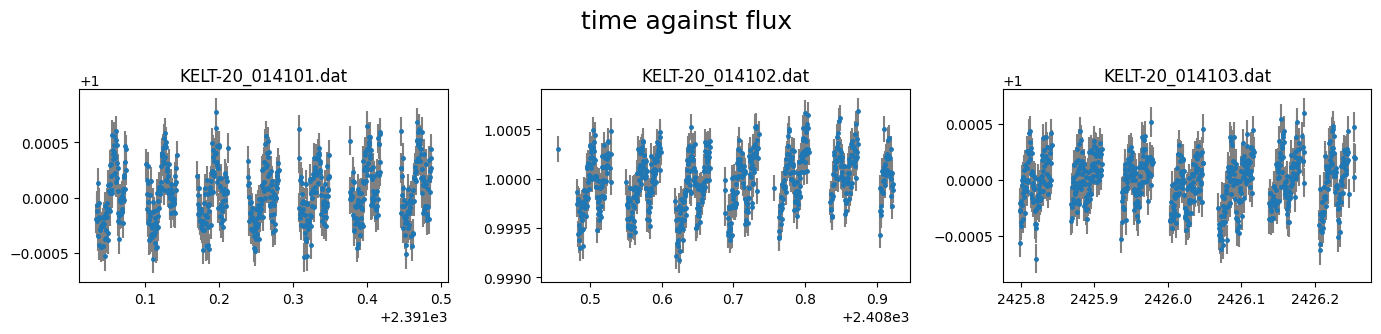

# ============ Input lightcurves, filters baseline function =======================================================
name               flt ùúÜ_ùúám |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
KELT-20_014101.dat CH1 0.1  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    0    0|n    1 n  None           
KELT-20_014102.dat CH2 0.2  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    0    0|n    2 n  None           
KELT-20_014103.dat CH3 0.3  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    0    0|n    3 n  None           


lightcurves from filepath: data/
1 transiting planet(s)
Order of unique filters: ['CH1', 'CH2', 'CH3']

In [3]:
lc_obj = CONAN.load_lightcurves(   file_list     = lc_list, 
                                    data_filepath = path, 
                                    filters       =[f"CH{i+1}" for i in range(len(lc_list))],
                                )

lc_obj.clip_outliers(width=11, clip=4, verbose=False)
lc_obj.rescale_data_columns(method = "med_sub", verbose=False)
lc_obj.plot()
lc_obj

setup planet parameters with the occultation depth ``D_occ`` as the only varying one

In [4]:
lc_obj.planet_parameters(   T_0          = 2459406.927174 - 2457000,      
                            Period       = 3.474074 ,          
                            Impact_para  = 0.515,      
                            RpRs         = 0.11572, 
                            Duration     = 0.13998861,
                        )

lc_obj.phasecurve(  D_occ = (-100,0,300))

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
rho_star/[Duration]        n   	F(0.13998861)                      	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs                       n   	F(0.11572)                         	#range[-0.5,0.5]
Impact_para                n   	F(0.515)                           	#range[0,2]
T_0                        n   	F(2406.9271740000695)              	#unit(days)
Period                     n   	F(3.474074)                        	#range[0,inf]days
[Eccentricity]/sesinw      n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega]/secosw             n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K                          n   	F(0)      

Notice the strong systematics in the `CHEOPS` lightcurves. they are mostly due to to correlation with the spacecraft roll angle (which is stored in column 5 of the data). we can visualize this correlation by plotting column 5 against the flux

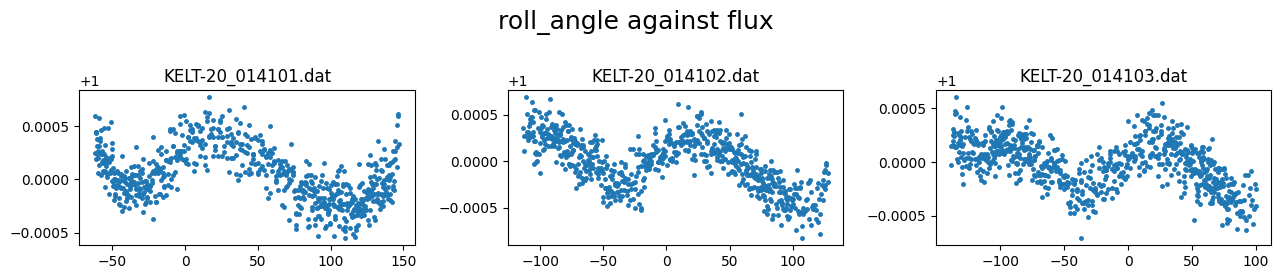

In [5]:
lc_obj.plot(plot_cols=(5,1), col_labels=("roll_angle","flux"), figsize= (13,3))

Different methods can be used to decorrelate the flux from the roll-angle. Here will try three methods:
- fit Spline as a function of the roll-angle 
- fit a combination of sines and cosines of the roll-angle (and the harmonics). 
- fit a GP as a function of roll-angle


if plotted together, the roll angle trend of these visits aligns nicely. For the sinusoid and GP fit, we will be able to fit the same roll-angle trend to the 3 visits

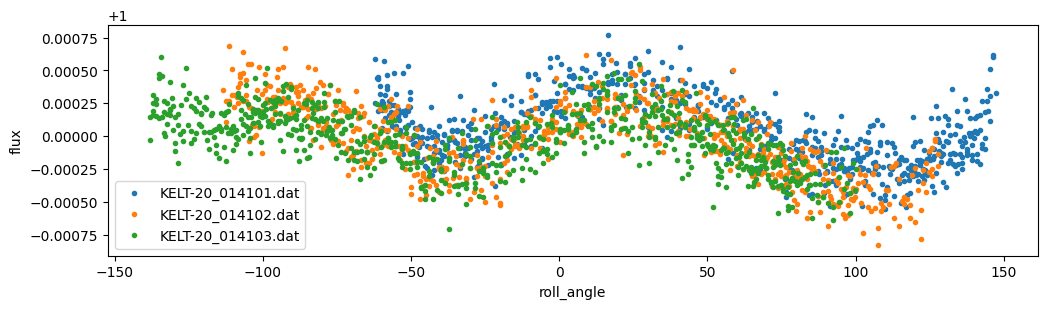

In [6]:
plt.figure(figsize=(12,3))
for lc in lc_obj._input_lc.keys():
    plt.plot(lc_obj._input_lc[lc]["col5"], lc_obj._input_lc[lc]["col1"],".", label=lc)
plt.legend()
plt.xlabel("roll_angle")
plt.ylabel("flux");

Besides the roll-angle trend, the flux can be correlated with other ancillary data. we can use the ``get_decorr()`` method to automatically find other significant correlations. But here we will manually select the column of the data to decorrelate against. Let's use  ``col7`` (contam) and ``col8`` (delta_T)

In [7]:
lc_obj.lc_baseline(dcol7=1, dcol8=1)

# ============ Input lightcurves, filters baseline function =======================================================
name               flt ùúÜ_ùúám |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
KELT-20_014101.dat CH1 0.1  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|n    1 n  None           
KELT-20_014102.dat CH2 0.2  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|n    2 n  None           
KELT-20_014103.dat CH3 0.3  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|n    3 n  None           


## Roll-angle spline fit 

In [8]:
#create a copy of the light curve object on which we will use the splines
lcobj_spl = deepcopy(lc_obj)

lcobj_spl.add_spline(lc_list="all", par="col5", degree=3, knot_spacing=50 )



# ============ Input lightcurves, filters baseline function =======================================================
name               flt ùúÜ_ùúám |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
KELT-20_014101.dat CH1 0.1  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    1 n  c5:d3k50       
KELT-20_014102.dat CH2 0.2  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    2 n  c5:d3k50       
KELT-20_014103.dat CH3 0.3  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    3 n  c5:d3k50       


In [9]:
fit_obj = CONAN.fit_setup(R_st=(1.617,0.05), verbose=False)
fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=200,verbose=False)


In [ ]:
create_configfile(lcobj_spl, None, fit_obj, 'spl_config.dat', both=True, verify=True)

configuration file saved as spl_config.dat
configuration file saved as spl_config.yaml


In [ ]:
result_spl = CONAN.run_fit(lcobj_spl, None, fit_obj, 
                            out_folder="result_KELT20_spl",
                            rerun_result=True)

## Roll-angle Sinusoid fit  

In [8]:
lcobj_sin = deepcopy(lc_obj)

#set trig='sincos' to use an addition of sin and cos in roll-angle upto order n. Amplitudes are in ppm
lcobj_sin.add_sinusoid( lc_list = "same",
                        trig    = "sincos",
                        n       = 3,
                        par     = "col5",
                        Amp     = (-2000,0,2000),  #same prior for all amplitudes
                        P       = 360,
                        x0      = 0,  #phase of the first sine
                        )

fitting same sinusoid to all LCs.
# ============ Input lightcurves, filters baseline function =======================================================
name               flt ùúÜ_ùúám |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
KELT-20_014101.dat CH1 0.1  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|y    1 n  None           
KELT-20_014102.dat CH2 0.2  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|y    2 n  None           
KELT-20_014103.dat CH3 0.3  |None c1:W11C4n1   med_sub |  y    0    0    0    0    0    1    1|y    3 n  None           
# ============ Sinusoidal signals: Amp*trig(2ùúã/P*(x-x0)) - trig=sin or cos or both added==========================
name/filt          trig     n_harmonics  x     Amp[ppm]            P                   x0                
same               sincos             3  col5  U(-2000,0,2000)     F(360)              F(0)              


In [9]:
fit_obj = CONAN.fit_setup(R_st=(1.617,0.05), verbose=False)
fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=200,verbose=False)


In [10]:
create_configfile(lcobj_sin, None, fit_obj, 'sine_config.yaml', 
                  both=True,verify=True)

configuration file saved as sine_config.dat
configuration file saved as sine_config.yaml


In [ ]:
result_sin = CONAN.run_fit(lcobj_sin, None, fit_obj, 
                            out_folder="result_KELT20_sin",
                            rerun_result=True)

## Roll-angle GP fit

In [13]:
lcobj_gp = lc_obj

In [14]:
lcobj_gp.add_GP(lc_list     = "same",            # same GP to be used to model all visits
                par         = "col5",           # independent variable for the GP
                kernel      = "mat32",          # kernel to use
                amplitude   = (10,146,700),     # ppm
                lengthscale = (10, 45, 100),     # in unit of col5 (degrees)
                gp_pck      = ["ce","ce","ce"]
                )       


# ============ Input lightcurves, filters baseline function =======================================================
name               flt ùúÜ_ùúám |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
KELT-20_014101.dat CH1 0.1  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    1 ce None           
KELT-20_014102.dat CH2 0.2  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    2 ce None           
KELT-20_014103.dat CH3 0.3  |None c1:W11C4n1   med_sub |  n    0    0    0    0    0    1    1|n    3 ce None           
# ============ Photometry GP properties (start newline with name of * or + to Xply or add a 2nd gp to last file) =========
name/filt          kern  par    h1:[Amp]           h2:[len_scale1]    h3:[Q,Œ∑,C,Œ±,b]     h4:[P]       
same               mat32 col5   U(10,146,700)      U(10,45,100)       None               None        


In [15]:
fit_obj = CONAN.fit_setup(R_st=(1.617,0.05), verbose=False)
fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=200,verbose=False)


In [16]:
create_configfile(lcobj_gp, None, fit_obj, 'gp_config.yaml', 
                  both=True,verify=True)

configuration file saved as gp_config.dat
configuration file saved as gp_config.yaml


In [ ]:
result_gp = CONAN.run_fit(lcobj_gp, None, fit_obj, 
                            out_folder="result_KELT20_gp",
                            rerun_result=True)

In [18]:
from CONAN import load_result

result = load_result("result_KELT20_gp")

['lc'] Output files, ['KELT-20_014101_lcout.dat', 'KELT-20_014102_lcout.dat', 'KELT-20_014103_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.


# Compare results 

In [12]:
from CONAN import compare_results
# load all results for comparison
comp = compare_results(["result_KELT20_spl", "result_KELT20_sin", "result_KELT20_gp"])

['lc'] Output files, ['KELT-20_014101_lcout.dat', 'KELT-20_014102_lcout.dat', 'KELT-20_014103_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.
['lc'] Output files, ['KELT-20_014101_lcout.dat', 'KELT-20_014102_lcout.dat', 'KELT-20_014103_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.
['lc']

### corner plot of selected parameters for the 3 results

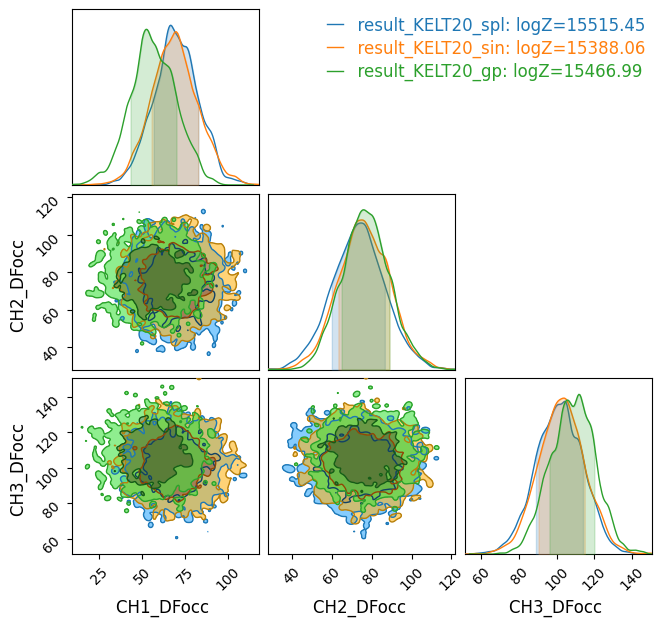

In [ ]:
occ_pars = ['CH1_DFocc','CH2_DFocc','CH3_DFocc']   #occultation depth of the 3 visits
comp.plot_distributions(pars = occ_pars, figsize=(7,7));

Notice that the evidence for each model fit is also shows and thus useful for comparison.  In this case, the spline model has the highest evidence.

### plot the fit of the raw data, including the systematic and occultation model

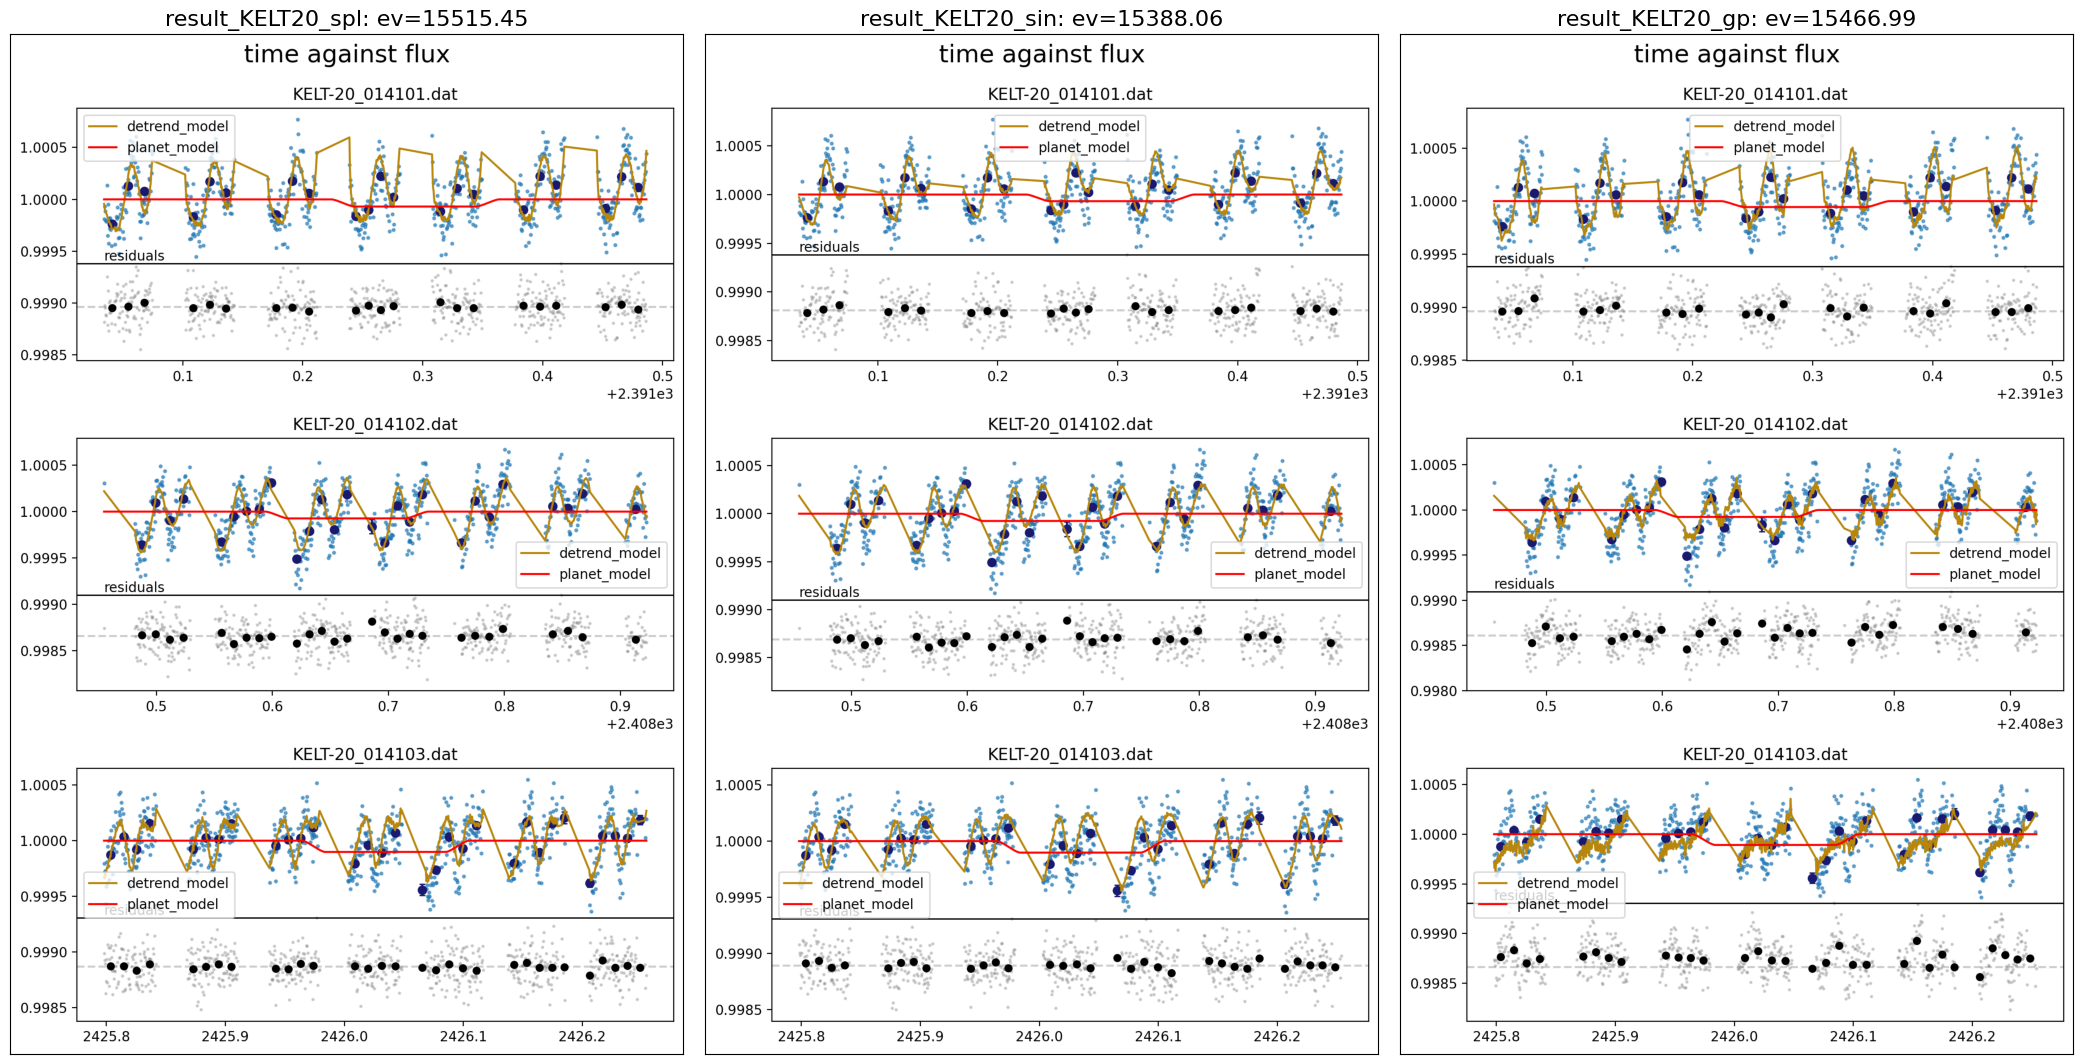

In [ ]:
comp.plot_lc();

Let's visualize how well the different methods model the roll-angle trend

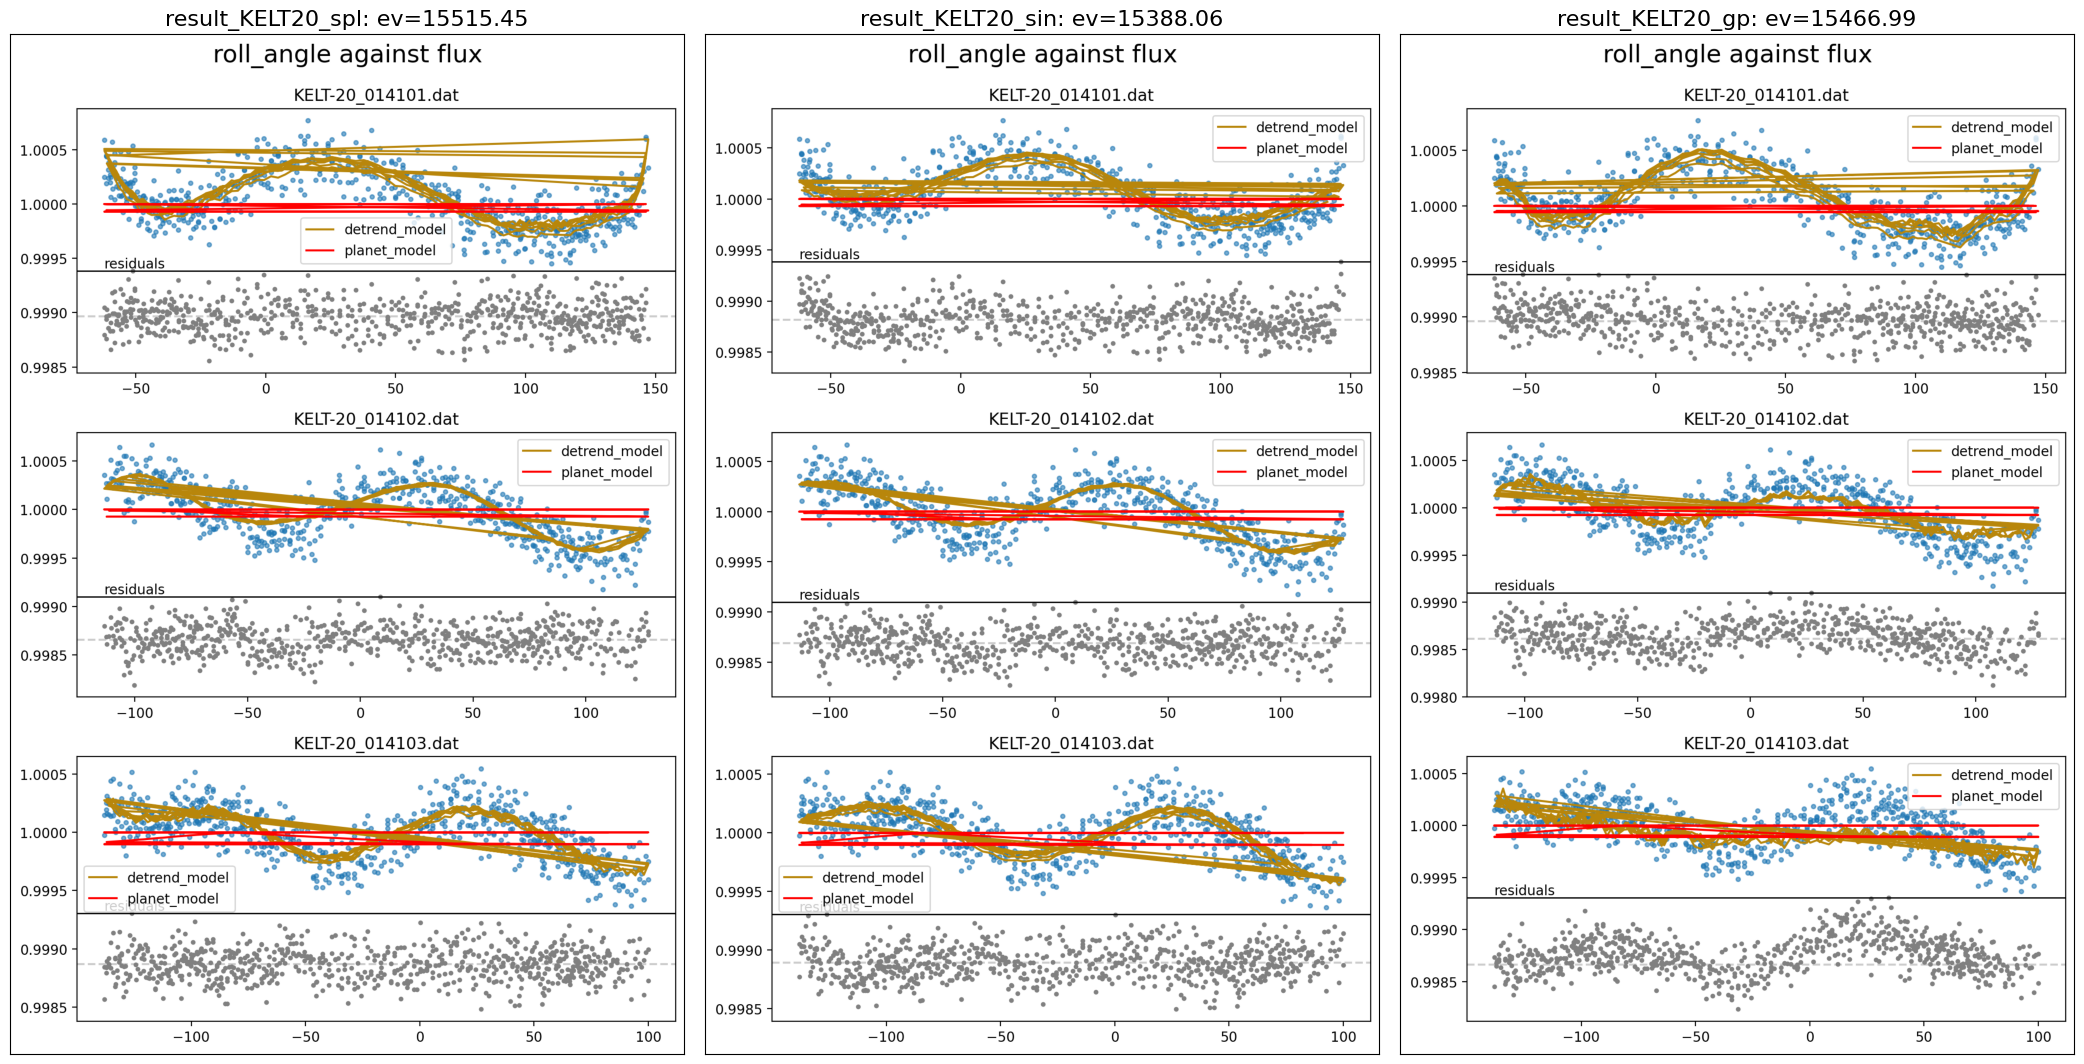

In [ ]:
comp.plot_lc(plot_cols=(5,1), col_labels=("roll_angle","flux"));

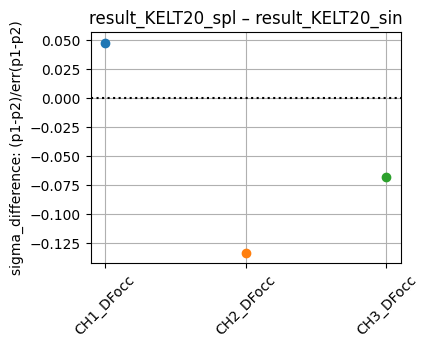

In [ ]:
comp.plot_param_sigma_diff(pars = occ_pars, res_index=[0,1], figsize=(4,3));

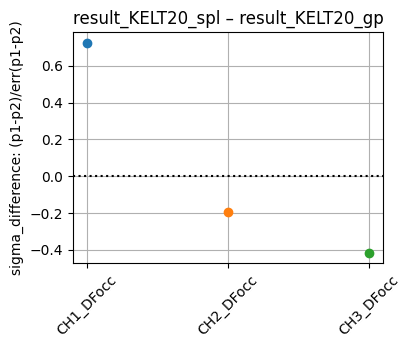

In [ ]:
comp.plot_param_sigma_diff(pars = occ_pars, res_index=[0,2], figsize=(4,3));

comparing the results, the occultation depths  for each visit are less than 1 sigma apart